In [ ]:
from google.colab import drive
#@title Loading Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title Imports
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from os import path, listdir
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Conv2DTranspose
import tensorflow as tf

In [ ]:
# Check if the TPU system has already been initialized
if 'COLAB_TPU_ADDR' in os.environ:
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
    tf.config.experimental_connect_to_cluster(resolver)
    tf.tpu.experimental.initialize_tpu_system(resolver)
    strategy = tf.distribute.TPUStrategy(resolver)
else:
    strategy = tf.distribute.OneDeviceStrategy('GPU:0')  # Use GPU if TPU is not available


In [ ]:
data_dir = '/content/drive/MyDrive/Datasets/BUSI_norm/normal'

# DATA PREPROCESSING

In [ ]:
def custom_data_generator(file_paths, batch_size, target_size=(64, 64)):
    while True:
        np.random.shuffle(file_paths)
        for i in range(0, len(file_paths), batch_size):
            batch_paths = file_paths[i:i+batch_size]
            images = []
            for path in batch_paths:
                img = load_img(path, target_size=target_size)
                img = img_to_array(img) / 255.0
                images.append(img)
            images = np.array(images)
            yield images, images  # Yield both input and target data

In [ ]:
# Load all data paths and labels
def load_image_paths(data_dir):
    data_gen = ImageDataGenerator(rescale=1./255)
    generator = data_gen.flow_from_directory(data_dir, target_size=(64, 64), batch_size=1, class_mode='input', shuffle=False)
    file_paths = [os.path.join(data_dir, path) for path in generator.filenames]
    return np.array(file_paths)

In [ ]:
train_dir = os.path.join(data_dir, 'train')
file_paths = load_image_paths(train_dir)

# Define KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Split file paths into train/validation sets
fold_indices = list(kf.split(file_paths))

Found 333 images belonging to 1 classes.


# DATA MODELLING

In [ ]:
def build_autoencoder(input_shape=(64, 64, 3)):
    input_img = Input(shape=input_shape)

    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)
    x = BatchNormalization()(x)

    # Latent space
    encoded = Conv2D(256, (3, 3), activation='relu', padding='same', name='encoded')(x)

    # Decoder
    x = Conv2DTranspose(256, (3, 3), activation='relu', padding='same')(encoded)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2DTranspose(128, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)
    x = BatchNormalization()(x)

    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    return autoencoder

In [ ]:
es = EarlyStopping(monitor='val_loss',start_from_epoch=50, mode='min', verbose=1, patience=10)

In [ ]:
def train_autoencoder(model, train_data, val_data, epochs=50, batch_size=32, steps_per_epoch=100, validation_steps=50):
    model.compile(optimizer='adam', loss='mse')

    history = model.fit(
        train_data,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_data,
        validation_steps=validation_steps,
        shuffle=True,
        callbacks=[es]
    )

    return history

In [ ]:
auto = build_autoencoder()

In [ ]:
auto.summary()

Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_100 (Conv2D)         (None, 64, 64, 32)        896       
                                                                 
 batch_normalization_150 (B  (None, 64, 64, 32)        128       
 atchNormalization)                                              
                                                                 
 conv2d_101 (Conv2D)         (None, 32, 32, 64)        18496     
                                                                 
 batch_normalization_151 (B  (None, 32, 32, 64)        256       
 atchNormalization)                                              
                                                                 
 conv2d_102 (Conv2D)         (None, 32, 32, 64)        369

Training fold 1
Epoch 1/100
8/8 [==============================] - 7s 424ms/step - loss: 0.0830 - val_loss: 0.0801
Epoch 2/100
8/8 [==============================] - 2s 302ms/step - loss: 0.0369 - val_loss: 0.1041
Epoch 3/100
8/8 [==============================] - 2s 294ms/step - loss: 0.0261 - val_loss: 0.0593
Epoch 4/100
8/8 [==============================] - 2s 270ms/step - loss: 0.0225 - val_loss: 0.0552
Epoch 5/100
8/8 [==============================] - 2s 281ms/step - loss: 0.0176 - val_loss: 0.0468
Epoch 6/100
8/8 [==============================] - 2s 280ms/step - loss: 0.0161 - val_loss: 0.0473
Epoch 7/100
8/8 [==============================] - 2s 267ms/step - loss: 0.0151 - val_loss: 0.0530
Epoch 8/100
8/8 [==============================] - 2s 277ms/step - loss: 0.0144 - val_loss: 0.0984
Epoch 9/100
8/8 [==============================] - 2s 273ms/step - loss: 0.0150 - val_loss: 0.0432
Epoch 10/100
8/8 [==============================] - 2s 283ms/step - loss: 0.0137 - val_loss: 

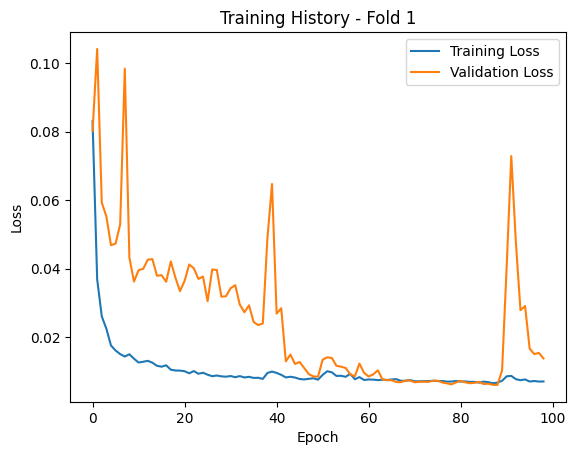

Training fold 2
Epoch 1/100
8/8 [==============================] - 7s 434ms/step - loss: 0.0079 - val_loss: 0.0141
Epoch 2/100
8/8 [==============================] - 2s 308ms/step - loss: 0.0079 - val_loss: 0.0157
Epoch 3/100
8/8 [==============================] - 2s 280ms/step - loss: 0.0068 - val_loss: 0.0179
Epoch 4/100
8/8 [==============================] - 2s 276ms/step - loss: 0.0072 - val_loss: 0.0088
Epoch 5/100
8/8 [==============================] - 2s 275ms/step - loss: 0.0073 - val_loss: 0.0080
Epoch 6/100
8/8 [==============================] - 2s 287ms/step - loss: 0.0074 - val_loss: 0.0115
Epoch 7/100
8/8 [==============================] - 2s 274ms/step - loss: 0.0075 - val_loss: 0.0093
Epoch 8/100
8/8 [==============================] - 2s 282ms/step - loss: 0.0074 - val_loss: 0.0104
Epoch 9/100
8/8 [==============================] - 2s 273ms/step - loss: 0.0069 - val_loss: 0.0110
Epoch 10/100
8/8 [==============================] - 2s 308ms/step - loss: 0.0068 - val_loss: 

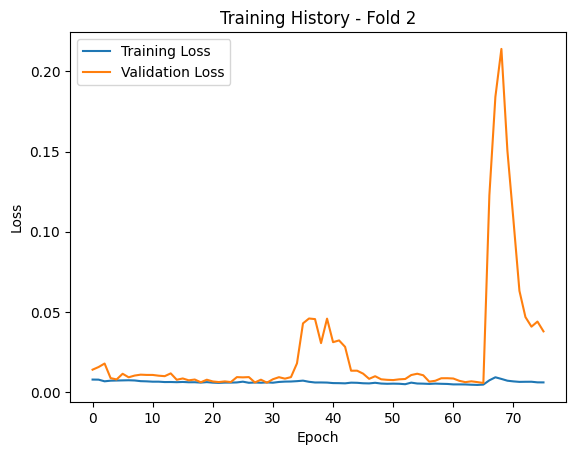

Training fold 3
Epoch 1/100
8/8 [==============================] - 7s 429ms/step - loss: 0.0063 - val_loss: 0.0351
Epoch 2/100
8/8 [==============================] - 2s 297ms/step - loss: 0.0058 - val_loss: 0.0286
Epoch 3/100
8/8 [==============================] - 2s 272ms/step - loss: 0.0054 - val_loss: 0.0226
Epoch 4/100
8/8 [==============================] - 2s 287ms/step - loss: 0.0055 - val_loss: 0.0168
Epoch 5/100
8/8 [==============================] - 2s 266ms/step - loss: 0.0052 - val_loss: 0.0167
Epoch 6/100
8/8 [==============================] - 2s 268ms/step - loss: 0.0054 - val_loss: 0.0140
Epoch 7/100
8/8 [==============================] - 2s 284ms/step - loss: 0.0055 - val_loss: 0.0076
Epoch 8/100
8/8 [==============================] - 2s 266ms/step - loss: 0.0055 - val_loss: 0.0079
Epoch 9/100
8/8 [==============================] - 2s 280ms/step - loss: 0.0052 - val_loss: 0.0074
Epoch 10/100
8/8 [==============================] - 2s 310ms/step - loss: 0.0050 - val_loss: 

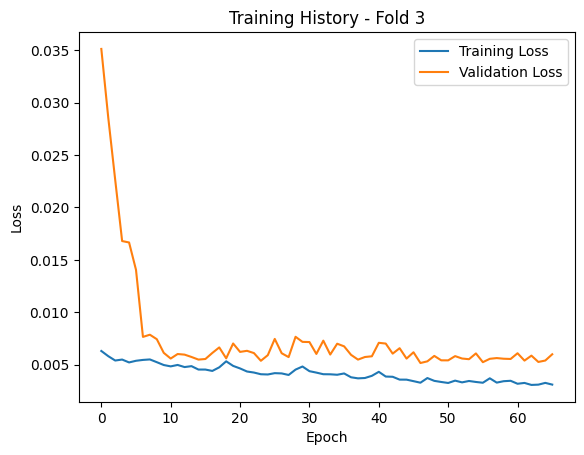

Training fold 4
Epoch 1/100
8/8 [==============================] - 9s 432ms/step - loss: 0.0041 - val_loss: 0.0033
Epoch 2/100
8/8 [==============================] - 2s 316ms/step - loss: 0.0036 - val_loss: 0.0033
Epoch 3/100
8/8 [==============================] - 2s 277ms/step - loss: 0.0034 - val_loss: 0.0031
Epoch 4/100
8/8 [==============================] - 2s 273ms/step - loss: 0.0036 - val_loss: 0.0037
Epoch 5/100
8/8 [==============================] - 2s 268ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 6/100
8/8 [==============================] - 2s 272ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 7/100
8/8 [==============================] - 2s 287ms/step - loss: 0.0035 - val_loss: 0.0042
Epoch 8/100
8/8 [==============================] - 2s 274ms/step - loss: 0.0036 - val_loss: 0.0049
Epoch 9/100
8/8 [==============================] - 2s 278ms/step - loss: 0.0045 - val_loss: 0.0057
Epoch 10/100
8/8 [==============================] - 2s 295ms/step - loss: 0.0044 - val_loss: 

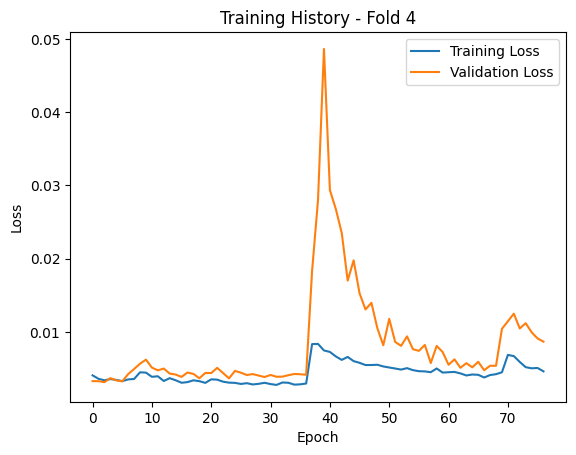

Training fold 5
Epoch 1/100
8/8 [==============================] - 7s 428ms/step - loss: 0.0049 - val_loss: 0.0072
Epoch 2/100
8/8 [==============================] - 2s 323ms/step - loss: 0.0046 - val_loss: 0.0068
Epoch 3/100
8/8 [==============================] - 2s 282ms/step - loss: 0.0043 - val_loss: 0.0073
Epoch 4/100
8/8 [==============================] - 2s 274ms/step - loss: 0.0043 - val_loss: 0.0053
Epoch 5/100
8/8 [==============================] - 2s 279ms/step - loss: 0.0042 - val_loss: 0.0054
Epoch 6/100
8/8 [==============================] - 2s 276ms/step - loss: 0.0040 - val_loss: 0.0052
Epoch 7/100
8/8 [==============================] - 2s 280ms/step - loss: 0.0041 - val_loss: 0.0051
Epoch 8/100
8/8 [==============================] - 2s 278ms/step - loss: 0.0039 - val_loss: 0.0051
Epoch 9/100
8/8 [==============================] - 2s 291ms/step - loss: 0.0036 - val_loss: 0.0046
Epoch 10/100
8/8 [==============================] - 2s 294ms/step - loss: 0.0038 - val_loss: 

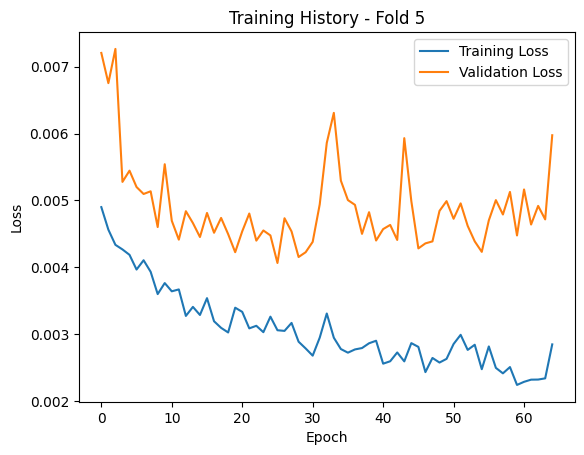

Training completed for all folds.


In [ ]:
# Train the autoencoder for each fold
for fold, (train_idx, val_idx) in enumerate(fold_indices):
    print(f"Training fold {fold + 1}")

    train_paths = file_paths[train_idx]
    val_paths = file_paths[val_idx]

    train_gen = custom_data_generator(train_paths, batch_size=32)
    val_gen = custom_data_generator(val_paths, batch_size=32)

    # Calculate steps_per_epoch and validation_steps
    steps_per_epoch = len(train_paths) // 32
    validation_steps = len(val_paths) // 32

    with strategy.scope():
        autoencoder = auto

    history = train_autoencoder(
        autoencoder,
        train_gen,
        val_gen,
        epochs=100,
        batch_size=32,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps
    )

    # Save the model
    autoencoder.save(f'/content/drive/MyDrive/Saved_models/Autoencoder-DOC/autoencoder_fold_{fold + 1}.h5')

    # Plot training history
    import matplotlib.pyplot as plt

    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Training History - Fold {fold + 1}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

print("Training completed for all folds.")

In [ ]:
def calculate_metrics(autoencoder, data_generator, threshold):
    y_true = []
    y_scores = []

    for images, _ in data_generator:
        reconstructed = autoencoder.predict(images)
        mse = np.mean(np.square(images - reconstructed), axis=(1, 2, 3))
        y_scores.extend(mse)
        y_true.extend([0] * len(mse))  # Since all data is normal, label is 0

    y_true = np.array(y_true)
    y_scores = np.array(y_scores)

    auc = roc_auc_score(y_true, y_scores)
    precision = precision_score(y_true, y_scores > threshold)
    recall = recall_score(y_true, y_scores > threshold)
    f1 = f1_score(y_true, y_scores > threshold)
    accuracy = accuracy_score(y_true, y_scores > threshold)

    return auc, precision, recall, f1, accuracy

In [ ]:
def plot_original_encoded_reconstructed(autoencoder, data_generator, num_images=4):
    # Get a batch of images
    original_images, _ = next(data_generator)
    original_images = original_images[:num_images]

    # Get the encoder part of the autoencoder
    encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('encoded').output)

    # Encode and reconstruct the images
    encoded_images = encoder.predict(original_images)
    reconstructed_images = autoencoder.predict(original_images)

    # Create a figure to display the images
    fig, axes = plt.subplots(3, num_images, figsize=(num_images * 4, 12))

    for i in range(num_images):
        # Display original image
        axes[0, i].imshow(original_images[i])
        axes[0, i].set_title('Original')
        axes[0, i].axis('off')

        # Display encoded image
        encoded_img = encoded_images[i].mean(axis=-1)
        axes[1, i].imshow(encoded_img, cmap='gray')
        axes[1, i].set_title('Encoded')
        axes[1, i].axis('off')

        # Display reconstructed image
        axes[2, i].imshow(reconstructed_images[i])
        axes[2, i].set_title('Reconstructed')
        axes[2, i].axis('off')

    plt.tight_layout()
    plt.show()

Evaluating and visualizing results for each fold:
Fold 1
1/1 [==============================] - 0s 289ms/step


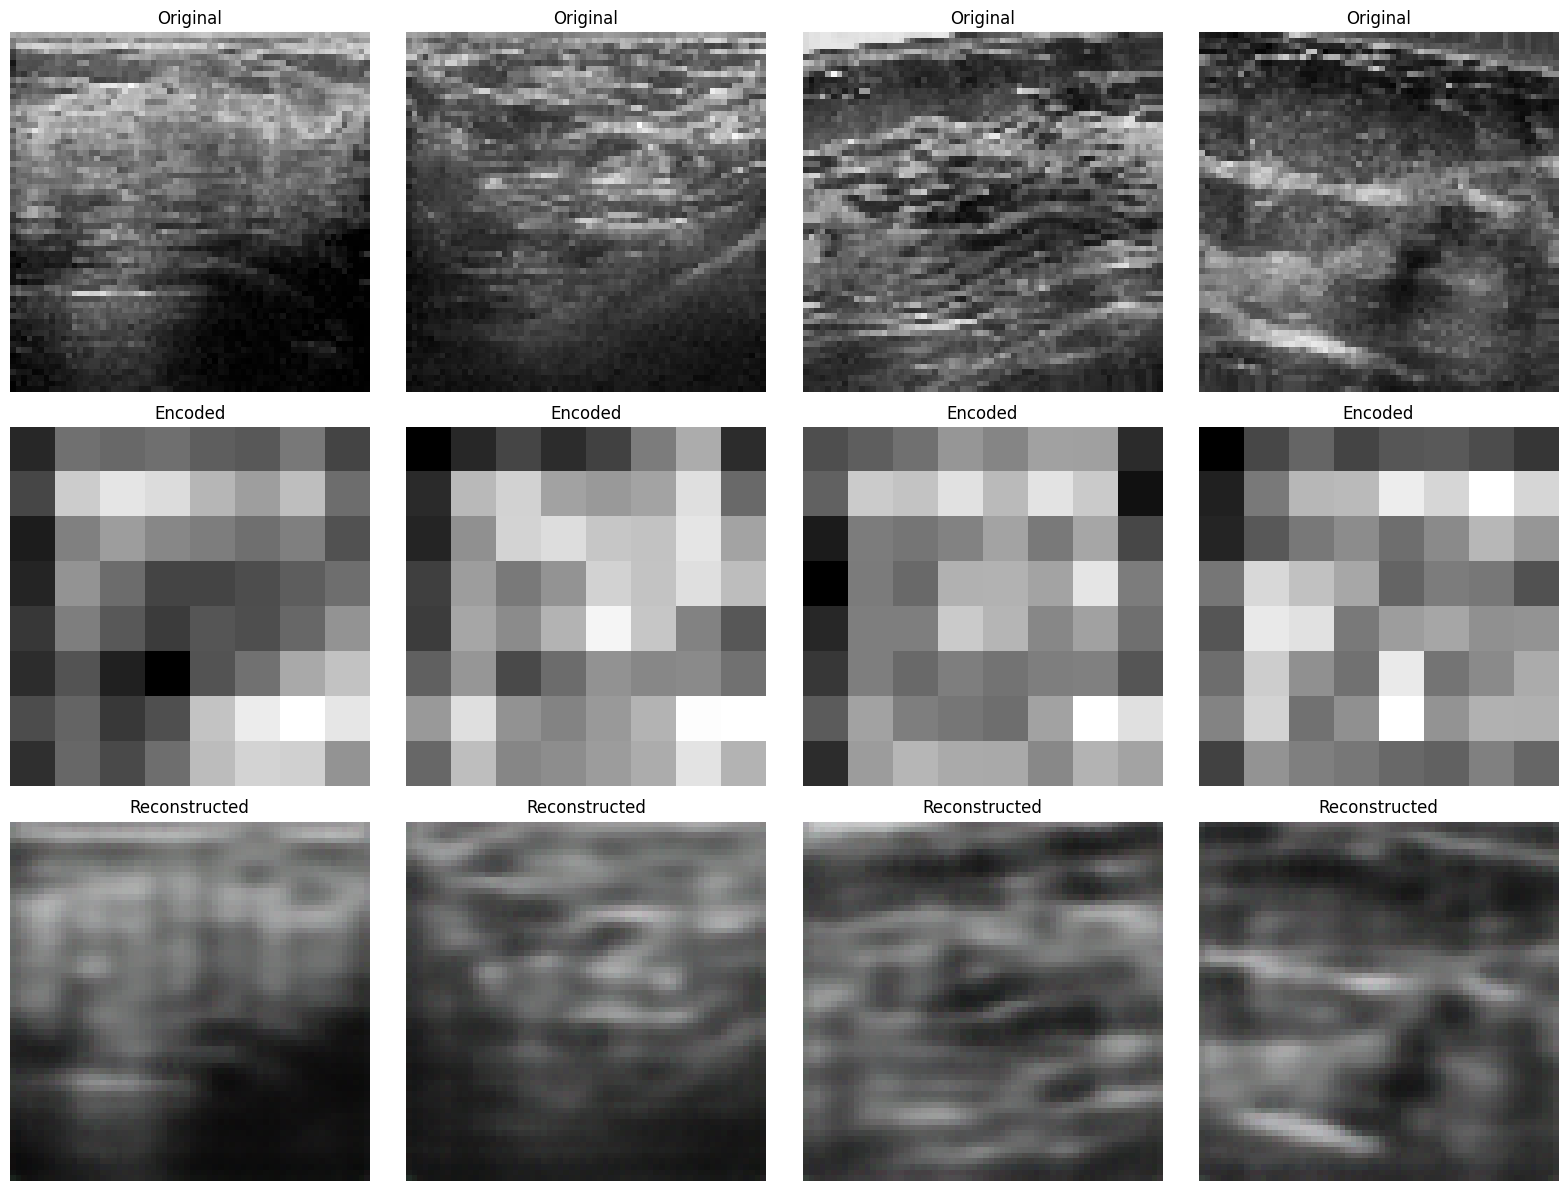

Fold 2
1/1 [==============================] - 0s 290ms/step


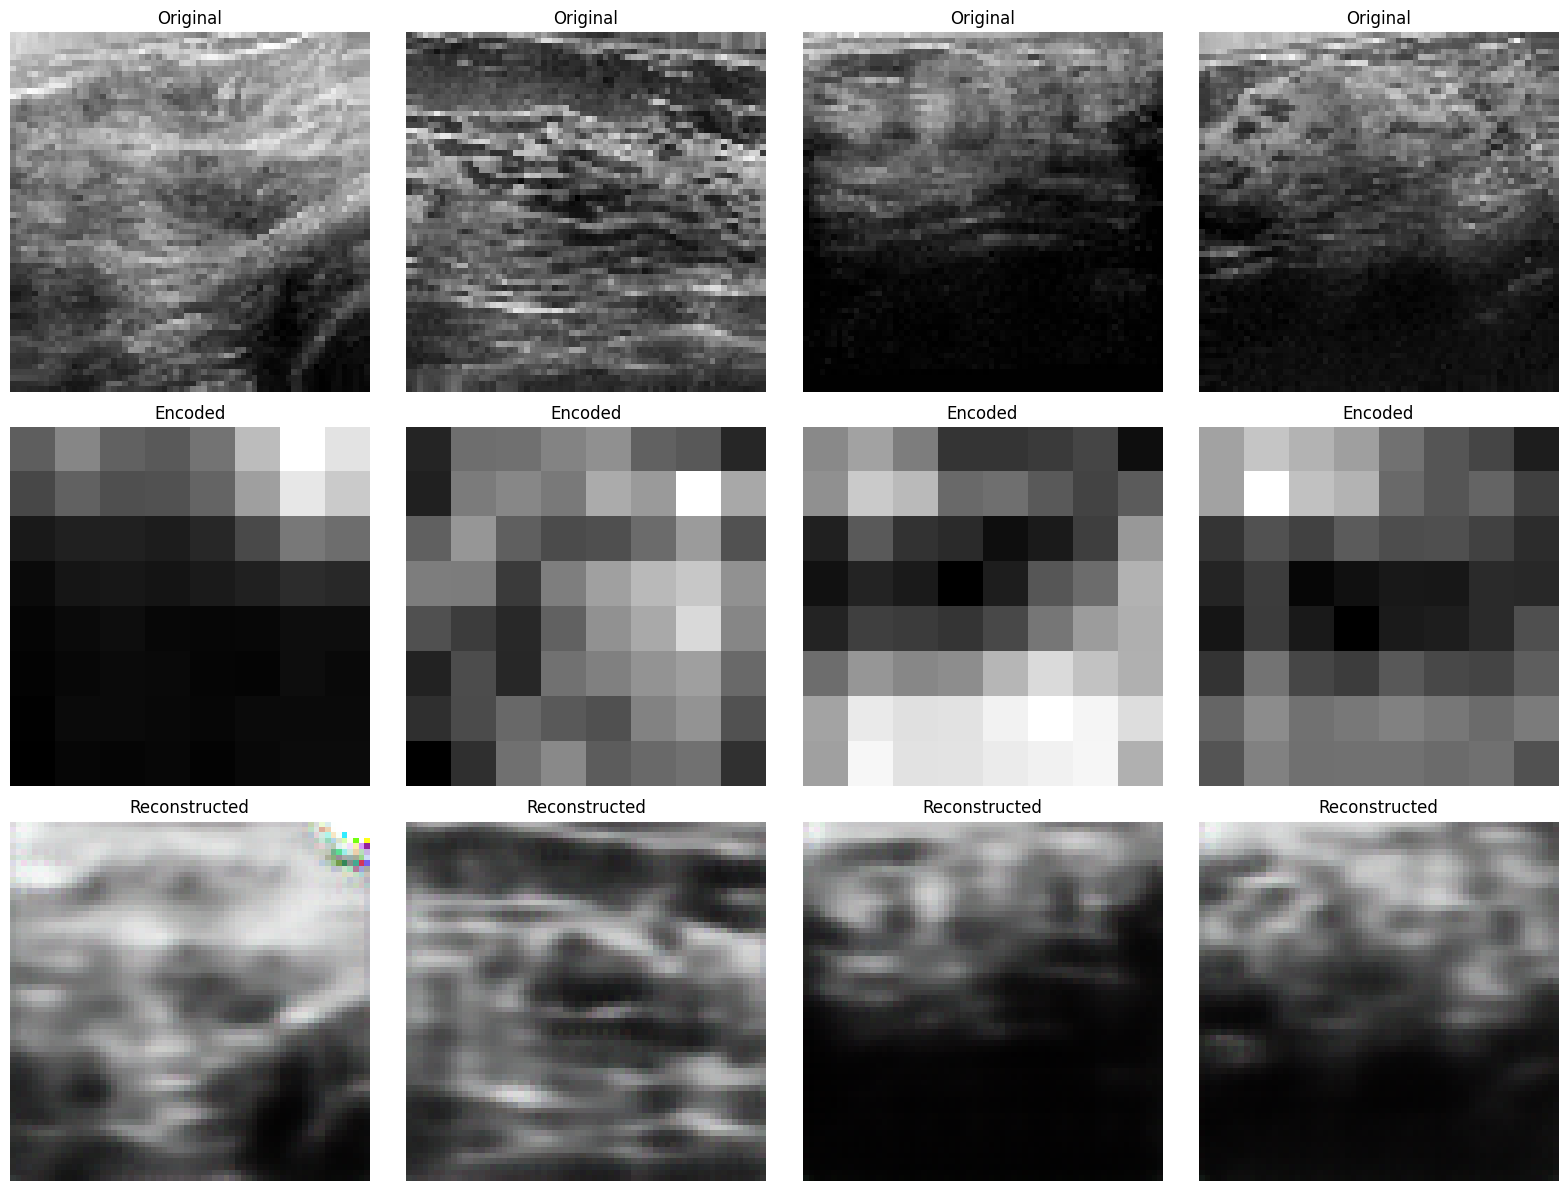

Fold 3
1/1 [==============================] - 0s 290ms/step


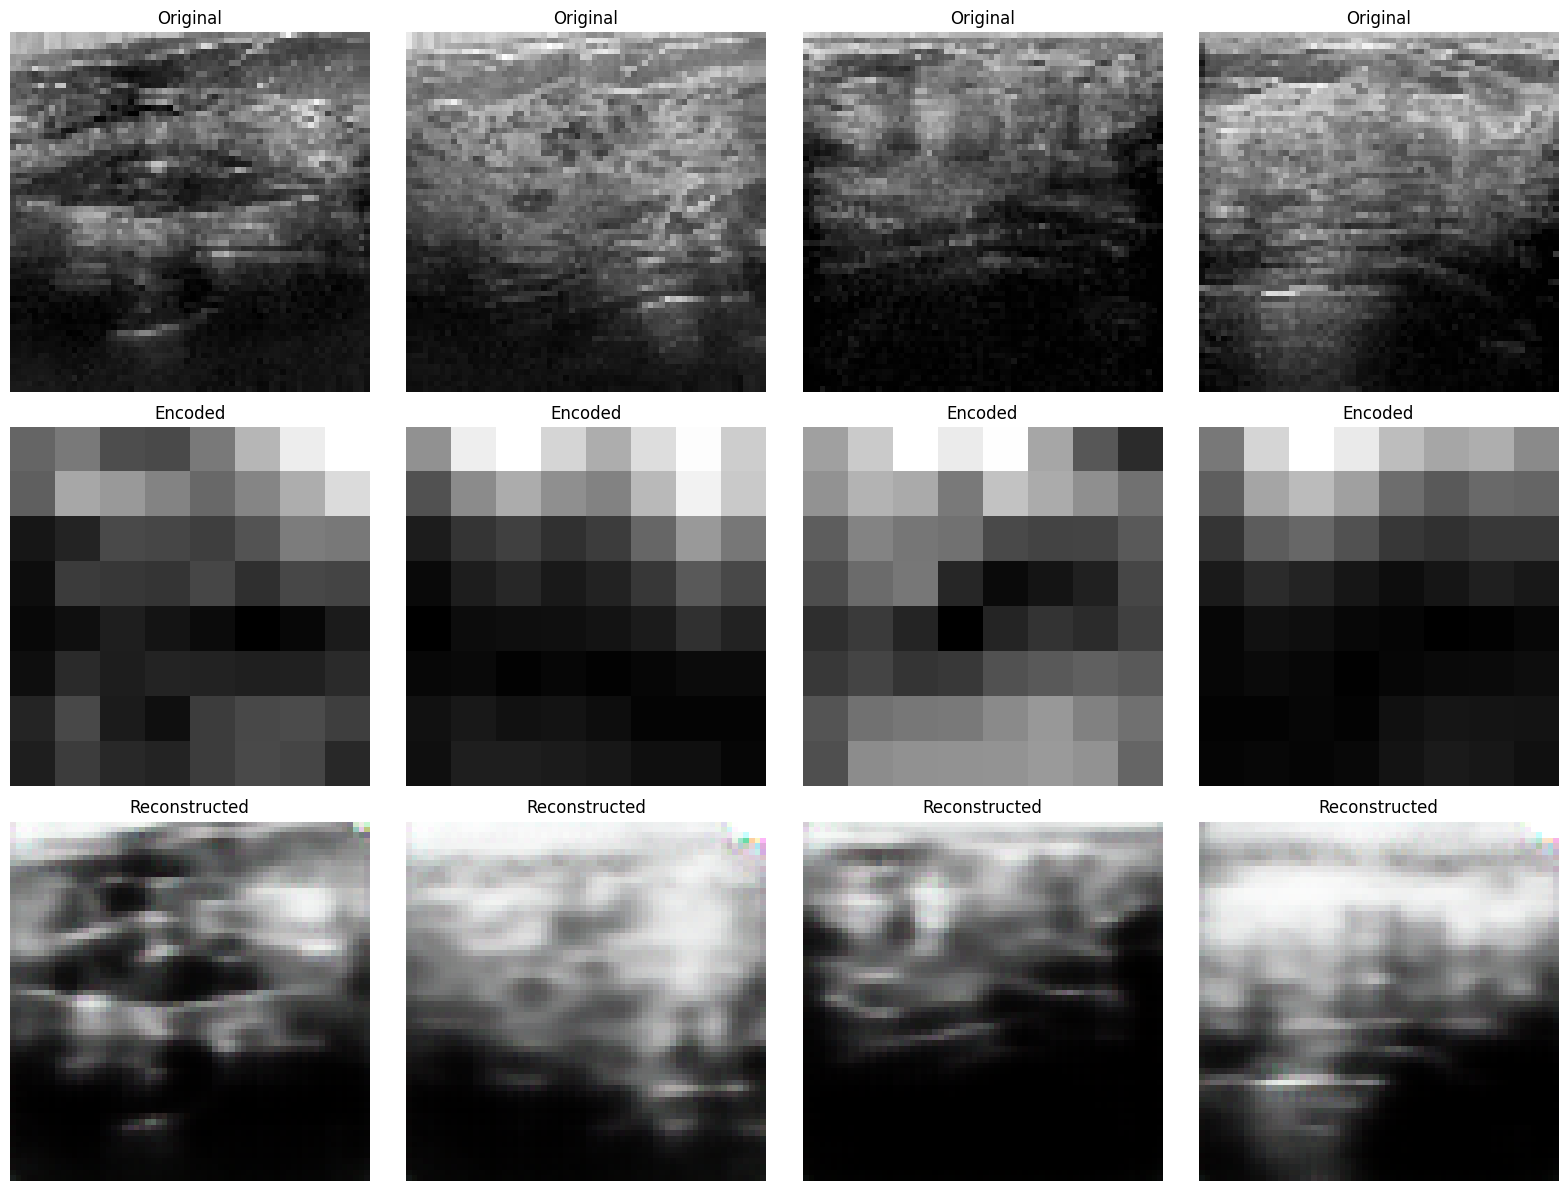

Fold 4
1/1 [==============================] - 0s 284ms/step


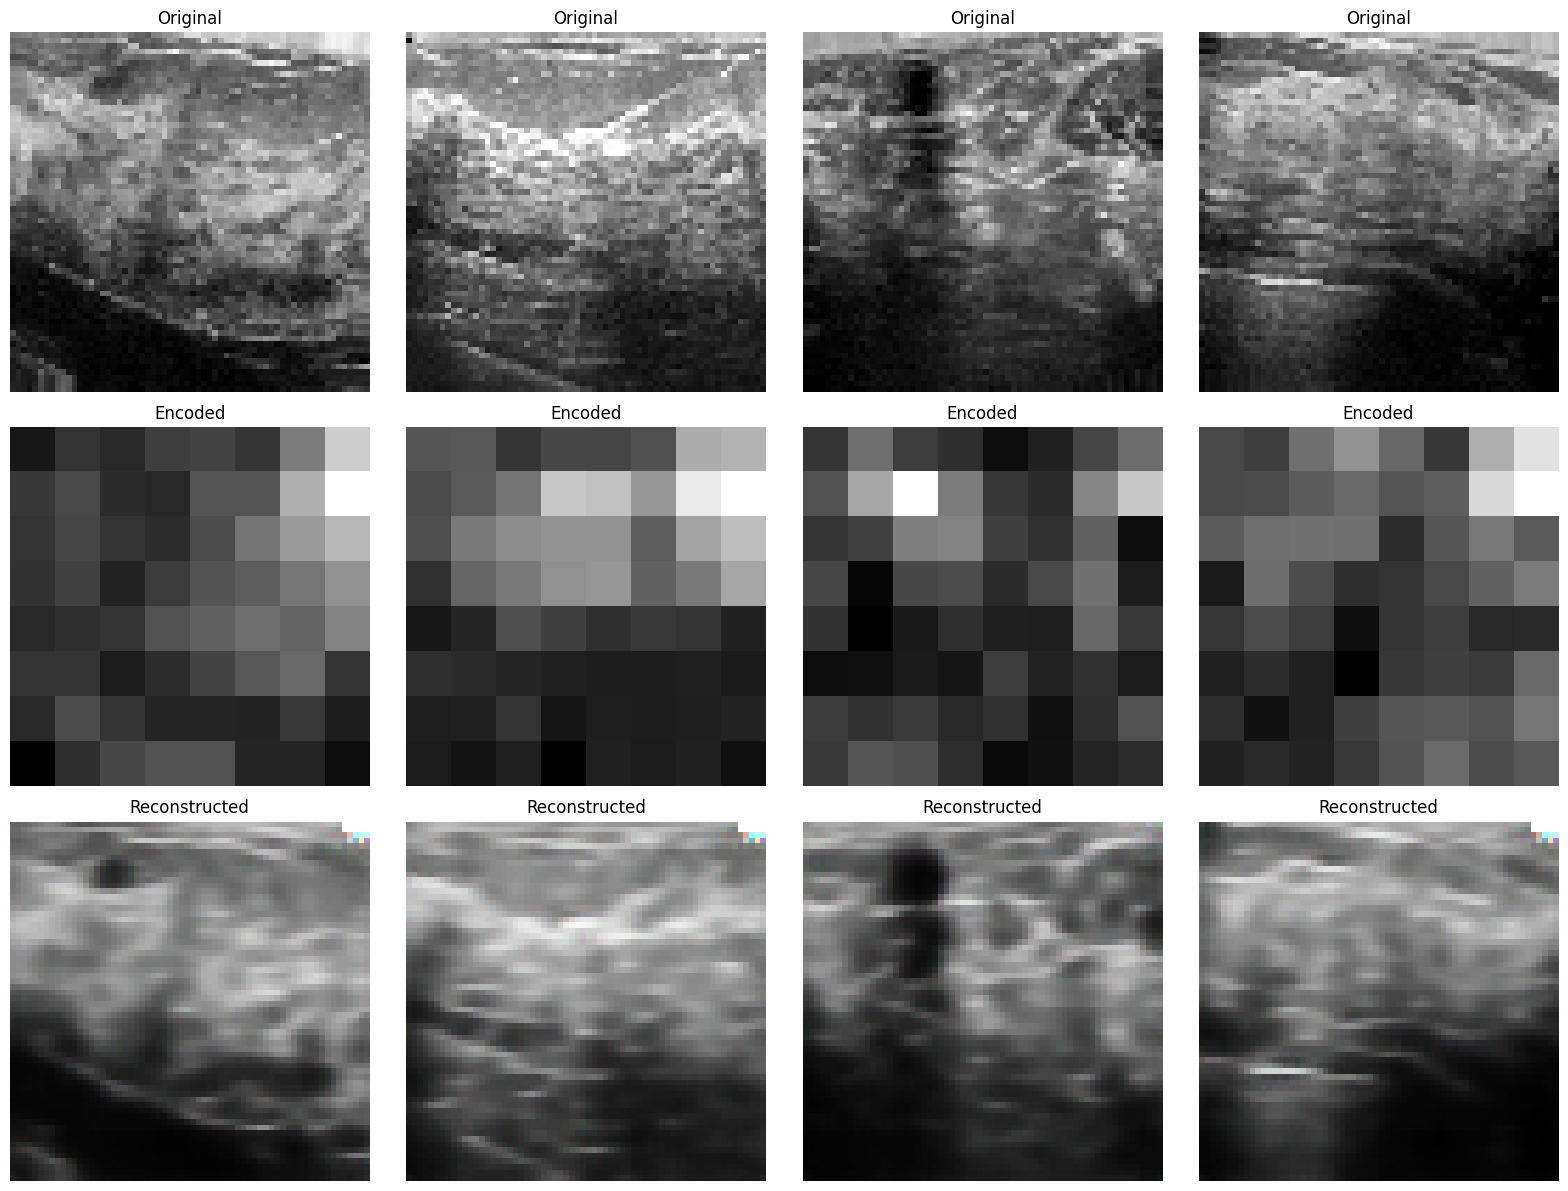

Fold 5
1/1 [==============================] - 0s 284ms/step


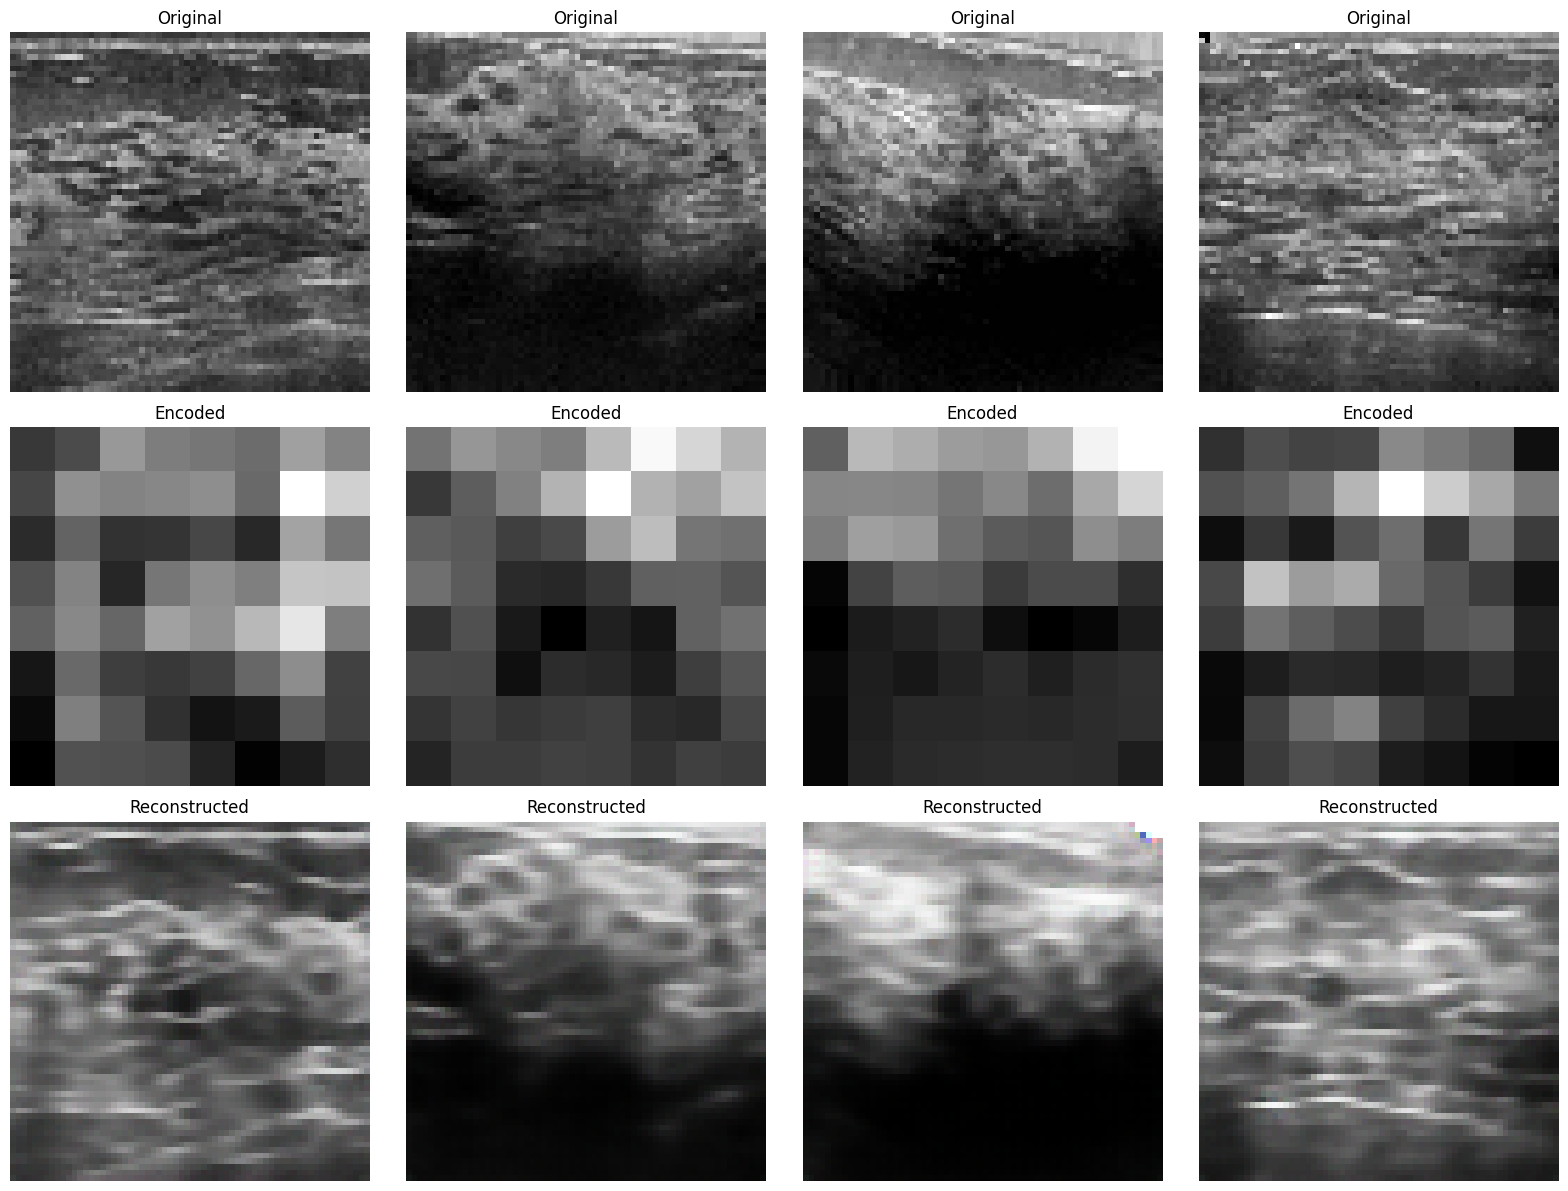

In [ ]:
# After the training loop
print("Evaluating and visualizing results for each fold:")

threshold = 0.01  # Set a threshold for anomaly detection

for fold, (train_idx, val_idx) in enumerate(fold_indices):
    print(f"Fold {fold + 1}")

    # Load the saved model
    autoencoder = tf.keras.models.load_model(f'autoencoder_fold_{fold + 1}.h5')

    # Create a new generator for visualization
    val_paths = file_paths[val_idx]
    val_gen = custom_data_generator(val_paths, batch_size=4)

    # Plot original, encoded, and reconstructed images
    plot_original_encoded_reconstructed(autoencoder, val_gen)

## Testing

In [ ]:
# Path to the test set
test_set_path = '/content/drive/MyDrive/Datasets/BUSI_norm/test'

def load_test_data(test_set_path):
    test_paths = []
    labels = []
    valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp']

    for label_folder in listdir(test_set_path):
        label_folder_path = path.join(test_set_path, label_folder)
        print(f'Checking folder: {label_folder_path}')

        if path.isdir(label_folder_path):
            # Check if folder name is 'normal' or 'abnormal' (case-insensitive)
            if label_folder.lower().startswith(('normal', 'abnormal')):
                if label_folder.lower().startswith('normal'):
                    label = 0
                else:
                    label = 1

                # Check for images in the folder
                num_images = 0
                for img_name in listdir(label_folder_path):
                    img_path = path.join(label_folder_path, img_name)
                    if path.isfile(img_path) and any(img_path.lower().endswith(ext) for ext in valid_extensions):
                        test_paths.append(img_path)
                        labels.append(label)
                        num_images += 1

                # Print message about images found
                if num_images == 0:
                    print(f'No images found in folder: {label_folder}')
                else:
                    print(f'Found {num_images} images in folder: {label_folder}')
            else:
                print(f'Skipping folder: {label_folder} (not labeled as normal or abnormal)')

    print(f'Test paths: {test_paths}')
    print(f'Labels: {labels}')
    return test_paths, labels

# Function to load BMP images and preprocess them
def load_and_preprocess_image(img_path, target_size=(64, 64)):
    img = Image.open(img_path)
    img = img.convert('RGB')  # Convert BMP to RGB format
    img = img.resize(target_size, Image.ANTIALIAS)  # Resize image
    img_array = img_to_array(img) / 255.0  # Convert to array and normalize
    return img_array

# Generator function for test data with preprocessing
def custom_test_data_generator(test_paths, labels, batch_size=4):
    while True:
        for start in range(0, len(test_paths), batch_size):
            end = min(start + batch_size, len(test_paths))
            batch_paths = test_paths[start:end]
            batch_labels = labels[start:end]
            batch_images = [load_and_preprocess_image(img_path) for img_path in batch_paths]
            yield np.array(batch_images), np.array(batch_labels)


In [ ]:
# Load test data
test_paths, test_labels = load_test_data(test_set_path)

Checking folder: /content/drive/MyDrive/Datasets/BUSI_norm/test/abnormal 
Found 20 images in folder: abnormal 
Checking folder: /content/drive/MyDrive/Datasets/BUSI_norm/test/.ipynb_checkpoints
Skipping folder: .ipynb_checkpoints (not labeled as normal or abnormal)
Checking folder: /content/drive/MyDrive/Datasets/BUSI_norm/test/normal
Found 20 images in folder: normal
Test paths: ['/content/drive/MyDrive/Datasets/BUSI_norm/test/abnormal /18 Benign Image.bmp', '/content/drive/MyDrive/Datasets/BUSI_norm/test/abnormal /19 Benign Image.bmp', '/content/drive/MyDrive/Datasets/BUSI_norm/test/abnormal /8 Benign Image.bmp', '/content/drive/MyDrive/Datasets/BUSI_norm/test/abnormal /11 Benign Image.bmp', '/content/drive/MyDrive/Datasets/BUSI_norm/test/abnormal /6 Benign Image.bmp', '/content/drive/MyDrive/Datasets/BUSI_norm/test/abnormal /7 Benign Image.bmp', '/content/drive/MyDrive/Datasets/BUSI_norm/test/abnormal /1 Benign Image.bmp', '/content/drive/MyDrive/Datasets/BUSI_norm/test/abnormal /17

In [ ]:
print(f'Test paths: {test_paths}')
print(f'Labels: {test_labels}')

Test paths: ['/content/drive/MyDrive/Datasets/BUSI_norm/test/abnormal /18 Benign Image.bmp', '/content/drive/MyDrive/Datasets/BUSI_norm/test/abnormal /19 Benign Image.bmp', '/content/drive/MyDrive/Datasets/BUSI_norm/test/abnormal /8 Benign Image.bmp', '/content/drive/MyDrive/Datasets/BUSI_norm/test/abnormal /11 Benign Image.bmp', '/content/drive/MyDrive/Datasets/BUSI_norm/test/abnormal /6 Benign Image.bmp', '/content/drive/MyDrive/Datasets/BUSI_norm/test/abnormal /7 Benign Image.bmp', '/content/drive/MyDrive/Datasets/BUSI_norm/test/abnormal /1 Benign Image.bmp', '/content/drive/MyDrive/Datasets/BUSI_norm/test/abnormal /17 Benign Image.bmp', '/content/drive/MyDrive/Datasets/BUSI_norm/test/abnormal /3 Benign Image.bmp', '/content/drive/MyDrive/Datasets/BUSI_norm/test/abnormal /15 Benign Image.bmp', '/content/drive/MyDrive/Datasets/BUSI_norm/test/abnormal /12 Benign Image.bmp', '/content/drive/MyDrive/Datasets/BUSI_norm/test/abnormal /9 Benign Image.bmp', '/content/drive/MyDrive/Datasets/

In [ ]:
# After the training loop
print("Evaluating and visualizing results for the test set:")

# Load the saved model (assuming a single final model is used for testing)
autoencoder_model = tf.keras.models.load_model('/content/drive/MyDrive/Saved_models/Autoencoder-DOC/autoencoder_fold_5.h5')

# Create a generator for the test set
test_gen = custom_test_data_generator(test_paths, test_labels, batch_size=4)
print(f'{test_gen}')

Evaluating and visualizing results for the test set:
<generator object custom_test_data_generator at 0x79771781d380>


In [ ]:
autoencoder_model.summary()

Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_100 (Conv2D)         (None, 64, 64, 32)        896       
                                                                 
 batch_normalization_150 (B  (None, 64, 64, 32)        128       
 atchNormalization)                                              
                                                                 
 conv2d_101 (Conv2D)         (None, 32, 32, 64)        18496     
                                                                 
 batch_normalization_151 (B  (None, 32, 32, 64)        256       
 atchNormalization)                                              
                                                                 
 conv2d_102 (Conv2D)         (None, 32, 32, 64)        369

In [ ]:
# Calculate reconstruction error for the test set
reconstruction_errors = []
test_labels_list = []
original_images = [[], []]
reconstructed_images = [[], []]

num_samples_per_class = 4

for images, labels in test_gen:
    reconstructed = autoencoder_model.predict(images)
    errors = np.mean((images - reconstructed) ** 2, axis=(1, 2, 3))  # Mean squared error per image

    for i in range(len(images)):
        label = labels[i]

        if len(original_images[label]) < num_samples_per_class:
            original_images[label].append(images[i])
            reconstructed_images[label].append(reconstructed[i])

        if len(original_images[0]) >= num_samples_per_class and len(original_images[1]) >= num_samples_per_class:
            break

    reconstruction_errors.extend(errors)
    test_labels_list.extend(labels)
    if len(reconstruction_errors) >= len(test_paths):
        break

<ipython-input-64-ab1120e499f1>:46: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize(target_size, Image.ANTIALIAS)  # Resize image


1/1 [==============================] - 0s 118ms/step


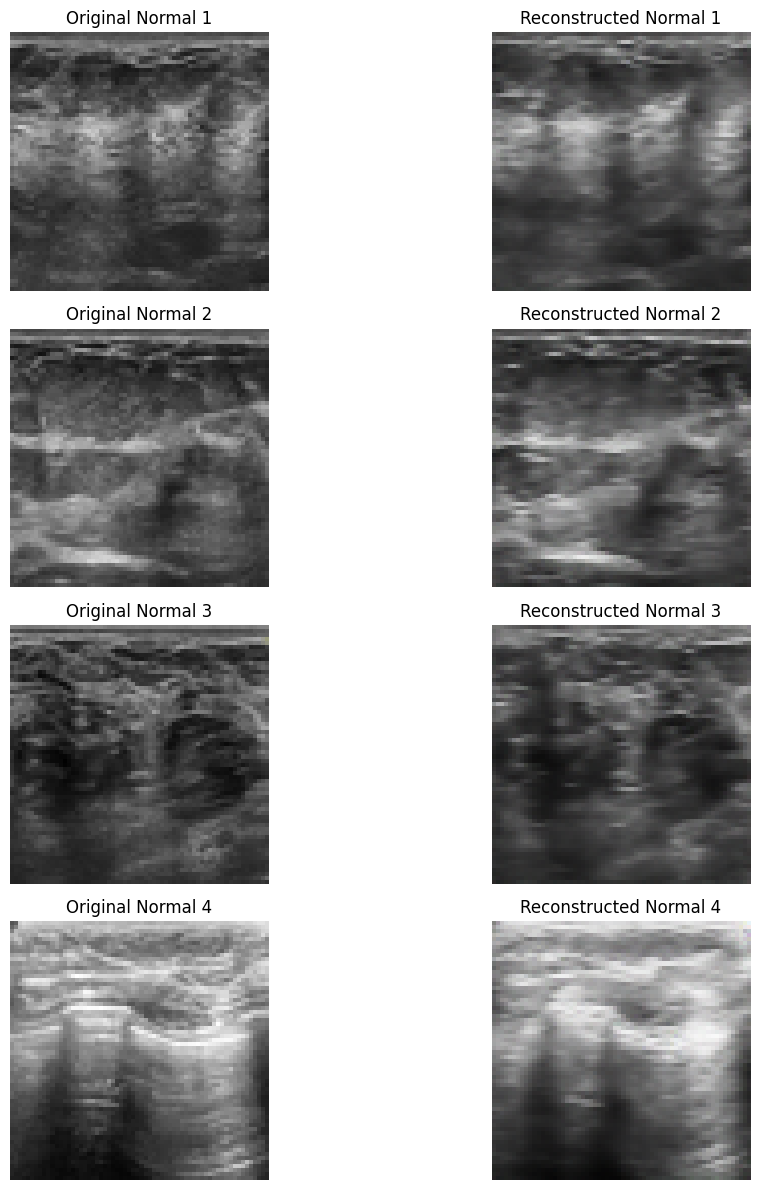

In [ ]:
# Plot original and reconstructed images for Normal class
fig, axes = plt.subplots(num_samples_per_class, 2, figsize=(12, 12))

for i in range(num_samples_per_class):
    axes[i, 0].imshow(original_images[0][i])
    axes[i, 0].set_title(f'Original Normal {i + 1}')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(reconstructed_images[0][i])
    axes[i, 1].set_title(f'Reconstructed Normal {i + 1}')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

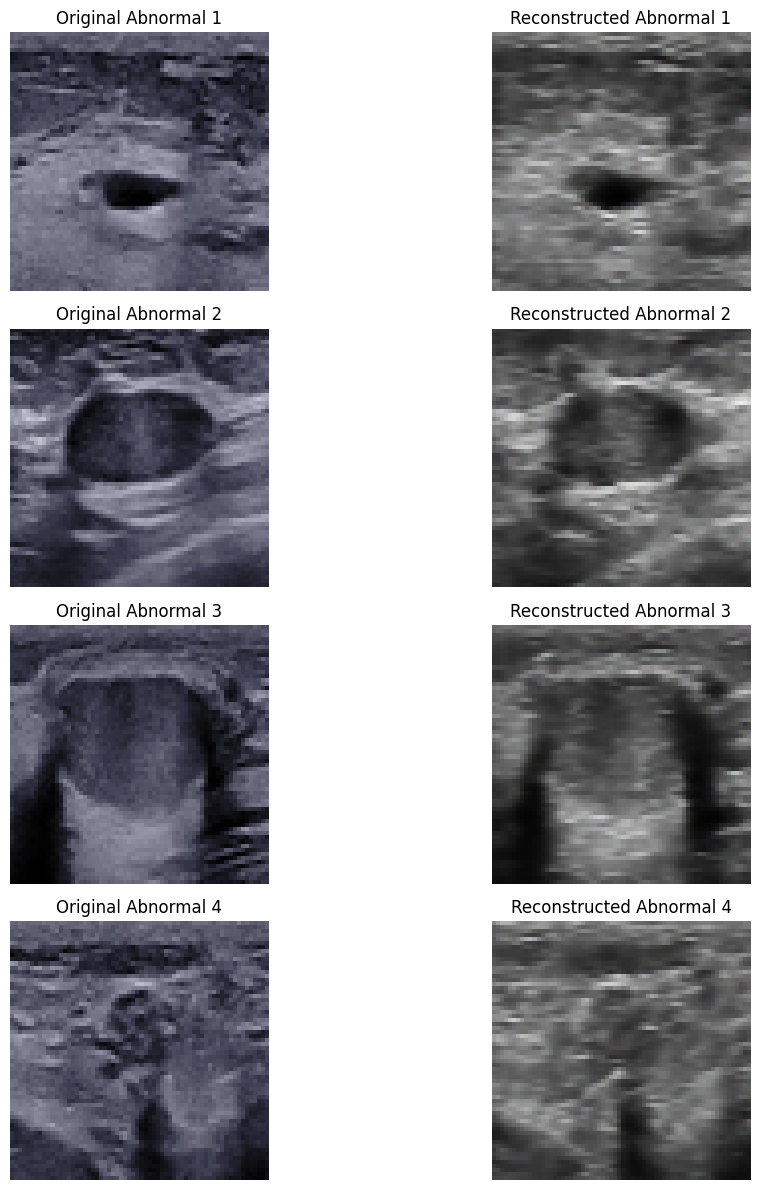

In [ ]:
# Plot original and reconstructed images for Abnormal class
fig, axes = plt.subplots(num_samples_per_class, 2, figsize=(12, 12))

for j in range(num_samples_per_class):
    axes[j, 0].imshow(original_images[1][j])
    axes[j, 0].set_title(f'Original Abnormal {j + 1}')
    axes[j, 0].axis('off')

    axes[j, 1].imshow(reconstructed_images[1][j])
    axes[j, 1].set_title(f'Reconstructed Abnormal {j + 1}')
    axes[j, 1].axis('off')

plt.tight_layout()
plt.show()


Reconstruction Errors: [0.00837916 0.008691   0.00660198 0.00889842 0.0092212  0.00707101
 0.00897404 0.00703    0.0069533  0.00789154 0.00653179 0.0101356
 0.00904537 0.01029817 0.00818115 0.0058741  0.00898288 0.00709663
 0.00834577 0.01115803 0.00445842 0.00489945 0.00342609 0.00607736
 0.00499969 0.00518403 0.00270075 0.00457897 0.0052249  0.0072233
 0.00418621 0.00533473 0.00478486 0.00488945 0.00476597 0.00477735
 0.00686138 0.00746413 0.00427371 0.00727356]
Mean Reconstruction Error: 0.006718635559082031
Test Labels: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Test Set ROC-AUC: 0.9375


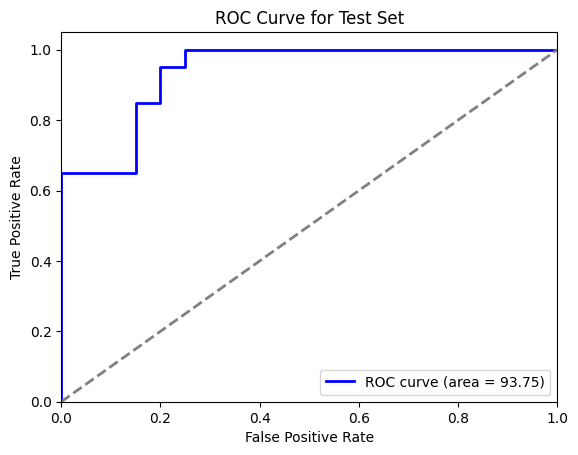

In [ ]:
reconstruction_errors = np.array(reconstruction_errors)
mean_reconstruction_error = np.mean(reconstruction_errors)
print(f'Reconstruction Errors: {reconstruction_errors}')
print(f'Mean Reconstruction Error: {mean_reconstruction_error}')
print(f'Test Labels: {test_labels_list}')
test_labels_list = np.array(test_labels_list)

# Calculate ROC-AUC for the test set
roc_auc = roc_auc_score(test_labels_list, reconstruction_errors)
print(f"Test Set ROC-AUC: {roc_auc:.4f}")

# Calculate ROC curve for the test set
fpr, tpr, thresholds = roc_curve(test_labels_list, reconstruction_errors)

# Plot ROC curve for the test set
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc*100:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Test Set')
plt.legend(loc='lower right')
plt.show()